# ML Dust Project - 2pop Size Distribution
## Install Lightning, Load Packages


In [1]:
import time
import pytorch_lightning as pl
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import astropy.units as u
import random
from scipy.ndimage import gaussian_filter1d
import matplotlib.gridspec as gridspec
from functions import scale
from functions import de_scale
from functions import normalize
from functions import normalize_one
from functions import de_normalize

def plot_model(modnum, mode = 'default'):
    fig, ax = plt.subplots(2,3, figsize=(16,10))

    if mode == 'default':
        Model  = Twopop
        dModdt = d_Twopop_dt
    elif mode == 'std':
        Model = Twopop_scaled
        dModdt = d_Twopop_dt_scaled
    elif mode == 'normed':
        Model = Twopop_normed
        dModdt = d_Twopop_dt_normed
  
    ax[0,0].plot(Model[150*modnum:int((modnum*150+150)),0], linewidth=3)
    #ax[0,0].set_xlabel('Time [yr]')
    ax[0,0].set_ylabel('Max. Particle Size [cm]')

    ax[0,1].plot(Model[150*modnum:int((modnum*150+150)),1], linewidth=3)
    #ax[0,1].set_xlabel('Time [yr]')
    ax[0,1].set_ylabel('2pop Densities $\sigma_0, \sigma_1 \, [\mathrm{g/cm^2}]$')

    ax[0,2].plot(Model[150*modnum:int((modnum*150+150)),2], linewidth=3)
    #ax[0,2].set_xlabel('Time [yr]')
    ax[0,2].set_ylabel('Power Law Index')

    ax[1,0].plot(dModdt[150*modnum:int((modnum*150+150)),0], linewidth=3)
    #ax[1,0].set_xlabel('Time [yr]')
    ax[1,0].set_ylabel('$\partial_t$ Max. Particle Size [cm]')

    ax[1,1].plot(dModdt[150*modnum:int((modnum*150+150)),1], linewidth=3)
    #ax[1,1].set_xlabel('Time [yr]')
    ax[1,1].set_ylabel('$\partial_t$ 2pop Densities $\sigma_0, \sigma_1 \, [\mathrm{g/cm^2}]$')

    # ax[1,2].plot(dModdt[150*modnum:int((modnum*150+150)),2], linewidth=3)
    # #ax[1,2].set_xlabel('Time [yr]')
    # ax[1,2].set_ylabel('$\partial_t$ Power Law Index')

    fig.tight_layout()

    del Model, dModdt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf']
plt.rcParams['axes.labelsize'] =8
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
plt.rcParams['legend.fontsize']=8
plt.rcParams['axes.linewidth']=1
plt.rcParams['ytick.major.width']=1
plt.rcParams['ytick.minor.width']=0.5
plt.rcParams['xtick.major.width']=1
plt.rcParams['xtick.minor.width']=0.5

FigsizeHalf = (3.36481291667,2)
FigsizeFull = (7.12663097223,3)

/home/thomas/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define a Plotting Function and a Function Printing Model Parameters

## Load 2pop Dust evolution Models

In [15]:
################################################################################
############################## Sim. Parameters #################################
#################     params[0] = M_star [M_sun]     ###########################
#################     params[1] = Tstar [K]          ###########################
#################     params[2] = M_disk [M_sun]     ###########################
#################     params[3] = turb. alpha        ###########################
#################     params[4] = dist. to star [au] ###########################
#################     params[5] = T_disk [K]         ###########################
#################     params[6] = Col. Den. [g/cm^2)]  #########################
#################     params[7] = d-to-g ratio       ###########################
#################     params[8] = afrag [cm]         ###########################
#################     params[9] = OmegaK [1/s]       ###########################
#################     params[10]= Growth time [s]    ###########################
################################################################################

# params = pd.read_csv("TrainingData/Parameters.csv").to_numpy()
params = pd.read_csv('https://github.com/ThomasPfeil/2popML/blob/main/TrainingData/Parameters.csv?raw=true').to_numpy()
Params150 = np.repeat(params, 150, axis=0).T

################################################################################
############################ Load as single file ###############################
#################          twopop[0] = time [yr]     ###########################
#################          twopop[1] = amax [cm]     ###########################
#################          twopop[2] = sig0 [g/cm^2] ###########################
#################          twopop[3] = sig1 [g/cm^2] ###########################
#################          twopop[4] = p             ###########################
################################################################################

# twopop     = pd.read_csv("TrainingData/Twopop.csv").to_numpy().T
twopop = pd.read_csv('https://github.com/ThomasPfeil/2popML/blob/main/TrainingData/Twopop.csv?raw=true').to_numpy().T
twopop[0] *= (u.yr).to(u.s) / Params150[10,:] # Convert time to units of local growth time scale

######################## Apply another Gaussian Filter #########################
for i in range(1000):
    twopop[1, 150*i:int((i*150+150))] = gaussian_filter1d(twopop[1, 150*i:int((i*150+150))], sigma=4)
    twopop[2, 150*i:int((i*150+150))] = gaussian_filter1d(twopop[2, 150*i:int((i*150+150))], sigma=4)
    twopop[3, 150*i:int((i*150+150))] = params[i,6]*params[i,7] - twopop[2, 150*i:int((i*150+150))]
    twopop[4, 150*i:int((i*150+150))] = np.log(twopop[3, 150*i:int((i*150+150))]/twopop[2, 150*i:int((i*150+150))]) / np.log(twopop[1, 150*i:int((i*150+150))]/(np.sqrt(1e-5*twopop[1, 150*i:int((i*150+150))]))) - 4.0
################################################################################

twopop2D   = twopop.reshape((5,1000,150))

################################################################################
################# Prepare to contain the following features ####################
#################          Twopop[0] = log(amax)            ####################
#################          Twopop[1] = sig1/sigtot          ####################
#################          Twopop[2] = p                    ####################
################################################################################

dtg150    = Params150[7,:]
sigg150   = Params150[6,:]

Twopop = twopop[[0,1,3,4],:]
Twopop[2] /= (sigg150*dtg150)

Twopop[1:3]         = np.log10(Twopop[1:3])
twopop2D[[1,3],:,:] = np.log10(twopop2D[[1,3],:,:])

# twopop2D[0,:,0] = 1e-10

d_Twopop_dt = np.zeros((2,150000))
for i in range(1000):
    d_Twopop_dt[:, 150*i:int((i*150+150))] = np.gradient(twopop2D[:,i,:], twopop2D[0,i,:], axis=-1)[[1,3],:]
    sign                                   = np.sign(d_Twopop_dt[:, 150*i:int((i*150+150))])
    d_Twopop_dt[:, 150*i:int((i*150+150))] = scale(d_Twopop_dt[:, 150*i:int((i*150+150))])

Twopop = np.vstack((Twopop[1:], Params150))

############################# Normalize to 0-1 #################################

offset_X = 0.0
offset_Y = 0.1

Twopop_min = np.array([-4.03606558e+00, -2.65798750e-01, -3.88600955e+00,  1.00000000e-02,
        2.38700000e+03,  5.00000000e-04,  2.07849373e-05,  3.98348191e-01,
        1.26285559e+01,  7.13785800e-03,  1.00060297e-04,  2.59646192e-04,
        2.85089556e-11,  1.27530476e+06])
Twopop_max = np.array([ 1.30393170e+00, -1.88744464e-03, -1.06036085e+00,  1.40000000e+00,
        4.64700000e+03,  7.00000000e-02,  9.99142339e-03,  9.95768777e+01,
        9.53677610e+02,  2.09191134e+02,  9.98244431e-01,  6.76239863e+01,
        9.31816503e-07,  1.01557331e+14])

Twopop_normed = normalize(Twopop, offset_X, Twopop_min, Twopop_max)

d_Twopop_dt_min = np.array([-1.1319893 , -0.98778142])
d_Twopop_dt_max = np.array([1.21161868, 1.12490773])

d_Twopop_dt_normed = normalize(d_Twopop_dt, offset_Y, d_Twopop_dt_min, d_Twopop_dt_max)

######################### Convert to pytorch tensor ############################

Twopop      = torch.tensor(Twopop.T, dtype=torch.float)
d_Twopop_dt = torch.tensor(d_Twopop_dt.T, dtype=torch.float)

# Twopop_scaled      = torch.tensor(Twopop_scaled.T, dtype=torch.float)
# d_Twopop_dt_scaled = torch.tensor(d_Twopop_dt_scaled.T, dtype=torch.float)

Twopop_normed      = torch.tensor(Twopop_normed.T, dtype=torch.float)
d_Twopop_dt_normed = torch.tensor(d_Twopop_dt_normed.T, dtype=torch.float)
print(np.shape(Twopop), np.shape(d_Twopop_dt))

torch.Size([150000, 14]) torch.Size([150000, 2])


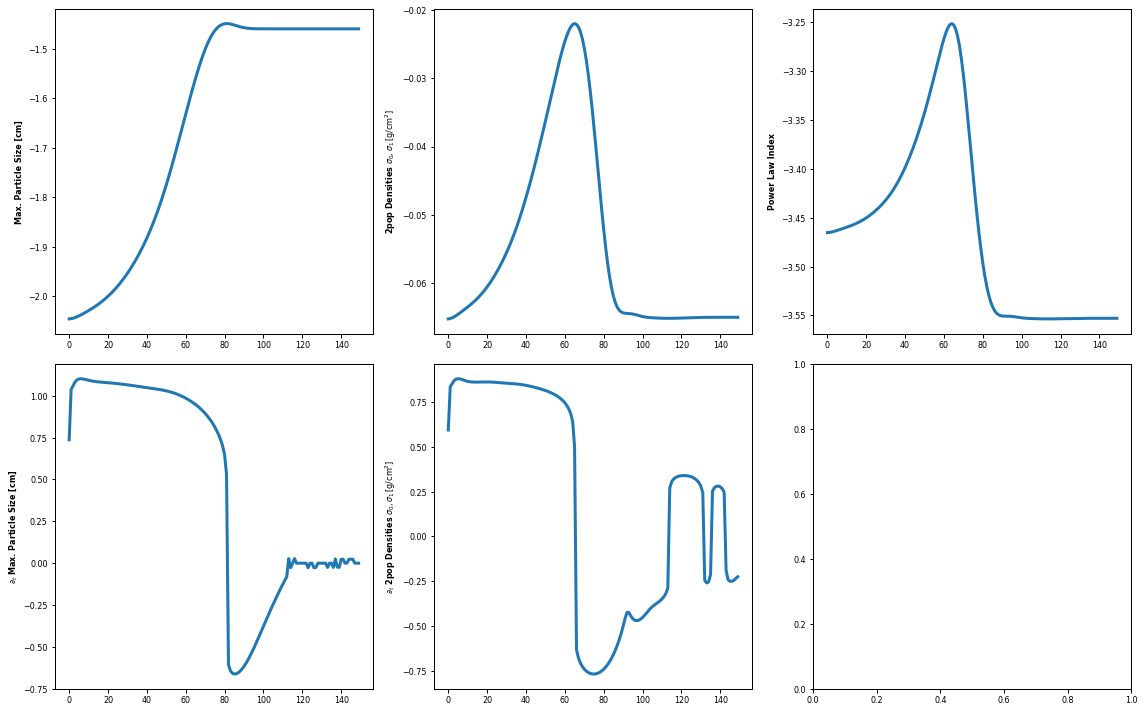

In [16]:
#######################################################
#################### Plot a Model #####################
#######################################################

ModelNum = 900
plot_model(modnum=ModelNum)

## Defining the Neural Network

In [17]:
import pytorch_lightning as pl

class NeuralNetwork(pl.LightningModule):
    def __init__(self, n_in, n_out, *, n_hidden=100):
        super().__init__()

        self.neural_net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out)
        )

        # Can manually declare parameters like so:
        self.scale = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, x):
        x = x * self.scale
        return self.neural_net(x)

In [18]:
model = NeuralNetwork(n_in=14, n_out=2, n_hidden=100)
model.load_state_dict(torch.load('Model/LongRun.pth'))
model.eval()

NeuralNetwork(
  (neural_net): Sequential(
    (0): Linear(in_features=14, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

0
200
400
600
800


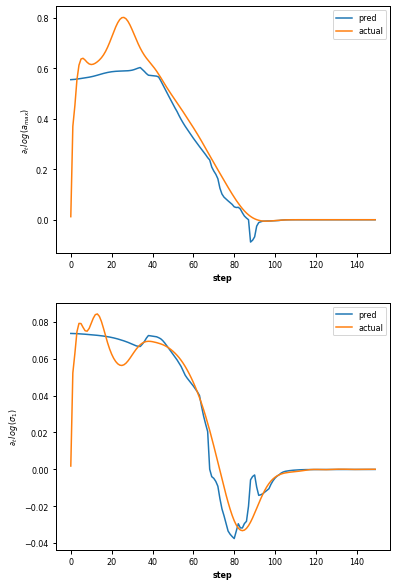

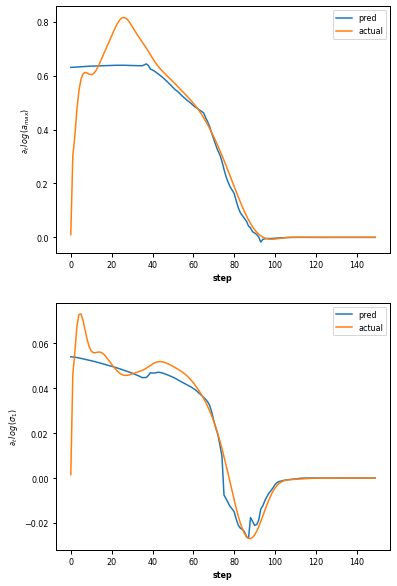

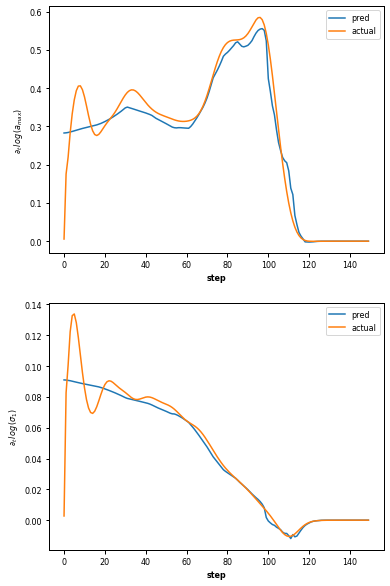

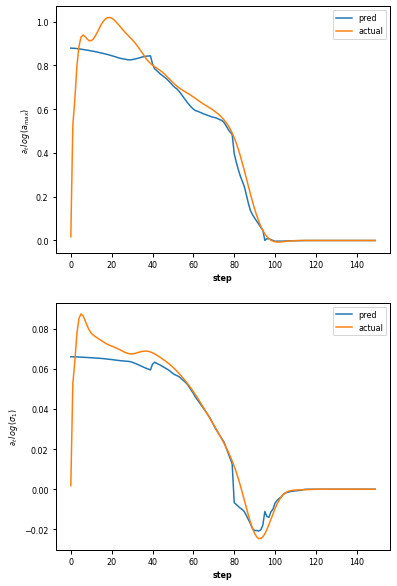

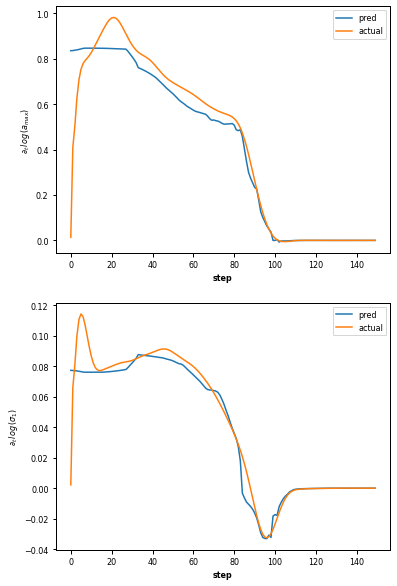

In [19]:
act  = np.zeros((150,2))
pred = np.zeros((150,2))

for j in np.arange(0, 1000, 200):
    k=0
    for i in range(150*j,int((j*150+150))):
        pred[k]   = de_normalize(np.array(model(Twopop_normed[i]).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y)
        sign_pred = np.sign(pred[k])
        pred[k]   = de_scale(pred[k])

        act[k]  = d_Twopop_dt[i,:2]
        sign_act = np.sign(act[k])
        act[k]   = de_scale(act[k])
        k+=1
        
    fig, ax = plt.subplots(2,1, figsize=(6,10))

    ax[0].plot(pred[:,0], label='pred')
    ax[0].plot(act[:,0], label='actual')
    ax[0].legend()
    ax[0].set_xlabel('step')
    ax[0].set_ylabel('$\partial_t \,log\,(a_{max})$')

    ax[1].plot(pred[:,1], label='pred')
    ax[1].plot(act[:,1], label='actual')
    ax[1].legend()
    ax[1].set_xlabel('step')
    ax[1].set_ylabel('$\partial_t \,log\,(\sigma_1)$')

    print(j)

## Test ML-Gradients + Numerical Integration 

In [7]:
%%time
modnum = 950

twopop_act = Twopop[modnum*150:modnum*150+150, :3]

twopop_num      = np.zeros((150, 14))
d_twopop_dt_num = np.zeros((150, 2))

d_twopop_dt_pred = np.zeros((150, 2))
d_twopop_dt_act = np.zeros((150, 2))

time = twopop2D[0,modnum,:]
dt   = np.diff(time)

k=0
for i in range(150*modnum,int((modnum*150+149))):
    ##############################################################################
    ############# Collect actual data and prediction on the way ##################
    ##############################################################################
    d_twopop_dt_pred[k]   = de_normalize(np.array(model(Twopop_normed[i]).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y)
    d_twopop_dt_pred[k]   = de_scale(d_twopop_dt_pred[k])

    d_twopop_dt_act[k]  = de_scale(d_Twopop_dt[i,:2])

    ##############################################################################
    #################### if k==0, set initial condtion ###########################
    ################# fill up twopop_num[3:] with parameters #####################
    ##############################################################################
    if k==0:
        twopop_num[0,:]  = Twopop[i,:]
        twopop_num[:,3:] = Twopop[i,3:]

    ##############################################################################
    #################### Numerically Integrate One Step ##########################
    ############################################################################## 

    tp_normed = normalize_one(twopop_num[k,:], Twopop_min, Twopop_max, offset_X)
    d_twopop_dt_num[k] = de_scale(de_normalize(np.array(model(torch.tensor(tp_normed, dtype=torch.float)).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y))
    twopop_num[k+1, :2] = np.maximum(-4.9, twopop_num[k, :2] + dt[k]*d_twopop_dt_num[k])
    
    amax = 10**twopop_num[k+1, 0]
    sigtot = dtg150[150*modnum] * sigg150[150*modnum] 
    sig1 = np.maximum(0.01, np.minimum(10**twopop_num[k+1, 1], 0.99)) * dtg150[150*modnum] * sigg150[150*modnum]
    sig0 = sigtot - sig1
    twopop_num[k+1, 2]  = np.maximum(-5, np.log(sig1/sig0)/np.log(amax/np.sqrt(amax*1e-5)) - 4.0)
    # print(amax, sig1/sigtot, sig0/sigtot, twopop_num[k+1, 2])

    k+=1

CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 68.6 ms


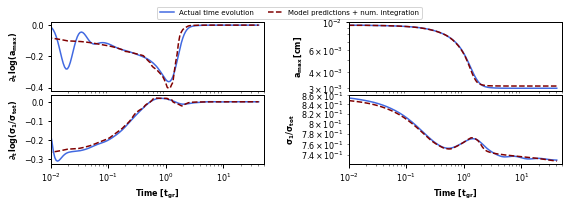

In [8]:
fig = plt.figure(figsize=(8,3))

outer  = gridspec.GridSpec(1, 1, figure=fig, wspace=0.0)
inner1 = outer[0].subgridspec(2, 2, wspace=0.4, hspace=0.05)

ax00  = fig.add_subplot(inner1[0,0])
ax01  = fig.add_subplot(inner1[0,1])
ax10  = fig.add_subplot(inner1[1,0])
ax11  = fig.add_subplot(inner1[1,1])

ax00.semilogx(time, d_twopop_dt_act[:,0], label='Actual time evolution', color='royalblue')
ax00.semilogx(time, d_twopop_dt_num[:,0], label='Model predictions + num. integration', color='maroon', linestyle='--')
ax00.set_ylabel('$\mathbf{\partial_t \,log(a_{\mathbf{max}})}$')

ax10.semilogx(time, d_twopop_dt_act[:,1], color='royalblue')
ax10.semilogx(time, d_twopop_dt_num[:,1], color='maroon', linestyle='--')
ax10.set_ylabel(r'$\mathbf{\partial_t \,log(\sigma_1/\sigma_{\mathbf{tot}})}$')

ax01.loglog(time, 10**twopop_act[:,0], label="Actual Time Series", color='royalblue')
ax01.loglog(time, 10**twopop_num[:,0], label="Num. Integr. with Pred. Gradients", color='maroon', linestyle='--')
ax01.set_ylabel('$\mathbf{a_{\mathbf{max}}  \, [cm]}$')

ax11.loglog(time, 10**twopop_act[:,1], color='royalblue')
ax11.loglog(time, 10**twopop_num[:,1], color='maroon', linestyle='--')
ax11.set_ylabel(r'$\mathbf{\sigma_1/\sigma_{\mathbf{tot}}}$')

ax00.set_xlim(1e-2,50)
ax01.set_xlim(1e-2,50)
ax10.set_xlim(1e-2,50)
ax11.set_xlim(1e-2,50)
ax00.set_xticks([])
ax01.set_xticks([])
ax00.legend(ncol=2, loc=(0.5,1.05), fontsize=7)

ax10.set_xlabel(r'Time [$\mathbf{t_{\mathbf{gr}}}$]')
ax11.set_xlabel(r'Time [$\mathbf{t_{\mathbf{gr}}}$]')

outer.tight_layout(fig)

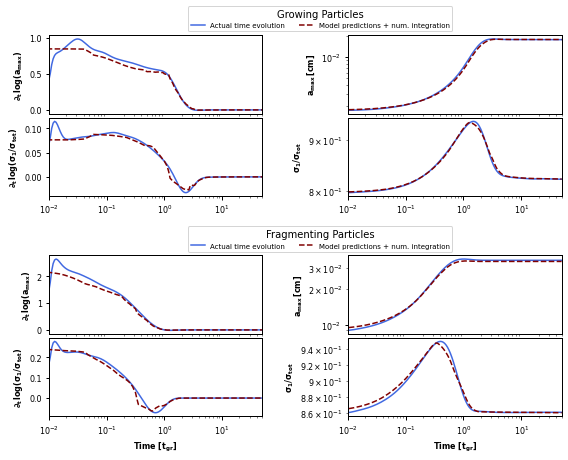

In [9]:
modnum = 800

twopop_act = Twopop[modnum*150:modnum*150+150, :3]

twopop_num      = np.zeros((150, 14))
d_twopop_dt_num = np.zeros((150, 2))

d_twopop_dt_pred = np.zeros((150, 2))
d_twopop_dt_act = np.zeros((150, 2))

time = twopop2D[0,modnum,:]
dt   = np.diff(time)

k=0
for i in range(150*modnum,int((modnum*150+149))):
    ##############################################################################
    ############# Collect actual data and prediction on the way ##################
    ##############################################################################
    d_twopop_dt_pred[k]   = de_normalize(np.array(model(Twopop_normed[i]).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y)
    d_twopop_dt_pred[k]   = de_scale(d_twopop_dt_pred[k])

    d_twopop_dt_act[k]  = de_scale(d_Twopop_dt[i,:2])

    ##############################################################################
    #################### if k==0, set initial condtion ###########################
    ################# fill up twopop_num[3:] with parameters #####################
    ##############################################################################
    if k==0:
        twopop_num[0,:]  = Twopop[i,:]
        twopop_num[:,3:] = Twopop[i,3:]

    ##############################################################################
    #################### Numerically Integrate One Step ##########################
    ############################################################################## 

    tp_normed = normalize_one(twopop_num[k,:], Twopop_min, Twopop_max, offset_X)
    d_twopop_dt_num[k] = de_scale(de_normalize(np.array(model(torch.tensor(tp_normed, dtype=torch.float)).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y))

    twopop_num[k+1, :2] = np.maximum(-4.9, twopop_num[k, :2] + dt[k]*d_twopop_dt_num[k])
    
    amax = 10**twopop_num[k+1, 0]
    sigtot = dtg150[150*modnum] * sigg150[150*modnum] 
    sig1 = np.maximum(0.01, np.minimum(10**twopop_num[k+1, 1], 0.99)) * dtg150[150*modnum] * sigg150[150*modnum]
    sig0 = sigtot - sig1
    twopop_num[k+1, 2]  = np.maximum(-5, np.log(sig1/sig0)/np.log(amax/np.sqrt(amax*1e-5)) - 4.0)
    # print(amax, sig1/sigtot, sig0/sigtot, twopop_num[k+1, 2])

    k+=1

fig = plt.figure(figsize=(8,6.5))

outer  = gridspec.GridSpec(2, 1, figure=fig, wspace=0.0)
inner1 = outer[0].subgridspec(2, 2, wspace=0.4, hspace=0.05)
inner2 = outer[1].subgridspec(2, 2, wspace=0.4, hspace=0.05)

ax00  = fig.add_subplot(inner1[0,0])
ax01  = fig.add_subplot(inner1[0,1])
ax10  = fig.add_subplot(inner1[1,0])
ax11  = fig.add_subplot(inner1[1,1])

ax00.semilogx(time, d_twopop_dt_act[:,0], label='Actual time evolution', color='royalblue')
ax00.semilogx(time, d_twopop_dt_num[:,0], label='Model predictions + num. integration', color='maroon', linestyle='--')
ax00.set_ylabel('$\mathbf{\partial_t \,log(a_{\mathbf{max}})}$')

ax10.semilogx(time, d_twopop_dt_act[:,1], color='royalblue')
ax10.semilogx(time, d_twopop_dt_num[:,1], color='maroon', linestyle='--')
ax10.set_ylabel(r'$\mathbf{\partial_t \,log(\sigma_1/\sigma_{\mathbf{tot}})}$')

ax01.loglog(time, 10**twopop_act[:,0], label="Actual Time Series", color='royalblue')
ax01.loglog(time, 10**twopop_num[:,0], label="Num. Integr. with Pred. Gradients", color='maroon', linestyle='--')
ax01.set_ylabel('$\mathbf{a_{\mathbf{max}}  \, [cm]}$')

ax11.loglog(time, 10**twopop_act[:,1], color='royalblue')
ax11.loglog(time, 10**twopop_num[:,1], color='maroon', linestyle='--')
ax11.set_ylabel(r'$\mathbf{\sigma_1/\sigma_{\mathbf{tot}}}$')

ax00.set_xlim(1e-2,50)
ax01.set_xlim(1e-2,50)
ax10.set_xlim(1e-2,50)
ax11.set_xlim(1e-2,50)
ax00.set_xticks([])
ax01.set_xticks([])
ax00.legend(ncol=2, loc=(0.65,1.05), fontsize=7, title='Growing Particles')

modnum = 900

twopop_act = Twopop[modnum*150:modnum*150+150, :3]

twopop_num      = np.zeros((150, 14))
d_twopop_dt_num = np.zeros((150, 2))

d_twopop_dt_pred = np.zeros((150, 2))
d_twopop_dt_act = np.zeros((150, 2))

time = twopop2D[0,modnum,:]
dt   = np.diff(time)

k=0
for i in range(150*modnum,int((modnum*150+149))):
    ##############################################################################
    ############# Collect actual data and prediction on the way ##################
    ##############################################################################
    d_twopop_dt_pred[k]   = de_normalize(np.array(model(Twopop_normed[i]).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y)
    d_twopop_dt_pred[k]   = de_scale(d_twopop_dt_pred[k])

    d_twopop_dt_act[k]  = de_scale(d_Twopop_dt[i,:2])

    ##############################################################################
    #################### if k==0, set initial condtion ###########################
    ################# fill up twopop_num[3:] with parameters #####################
    ##############################################################################
    if k==0:
        twopop_num[0,:]  = Twopop[i,:]
        twopop_num[:,3:] = Twopop[i,3:]

    ##############################################################################
    #################### Numerically Integrate One Step ##########################
    ############################################################################## 

    tp_normed = normalize_one(twopop_num[k,:], Twopop_min, Twopop_max, offset_X)
    d_twopop_dt_num[k] = de_scale(de_normalize(np.array(model(torch.tensor(tp_normed, dtype=torch.float)).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y))

    twopop_num[k+1, :2] = np.maximum(-4.9, twopop_num[k, :2] + dt[k]*d_twopop_dt_num[k])
    
    amax = 10**twopop_num[k+1, 0]
    sigtot = dtg150[150*modnum] * sigg150[150*modnum] 
    sig1 = np.maximum(0.01, np.minimum(10**twopop_num[k+1, 1], 0.99)) * dtg150[150*modnum] * sigg150[150*modnum]
    sig0 = sigtot - sig1
    twopop_num[k+1, 2]  = np.maximum(-5, np.log(sig1/sig0)/np.log(amax/np.sqrt(amax*1e-5)) - 4.0)
    # print(amax, sig1/sigtot, sig0/sigtot, twopop_num[k+1, 2])

    k+=1


ax20  = fig.add_subplot(inner2[0,0])
ax21  = fig.add_subplot(inner2[0,1])
ax30  = fig.add_subplot(inner2[1,0])
ax31  = fig.add_subplot(inner2[1,1])

ax20.semilogx(time, d_twopop_dt_act[:,0], label='Actual time evolution', color='royalblue')
ax20.semilogx(time, d_twopop_dt_num[:,0], label='Model predictions + num. integration', color='maroon', linestyle='--')
ax20.set_ylabel('$\mathbf{\partial_t \,log(a_{\mathbf{max}})}$')

ax30.semilogx(time, d_twopop_dt_act[:,1], color='royalblue')
ax30.semilogx(time, d_twopop_dt_num[:,1], color='maroon', linestyle='--')
ax30.set_ylabel(r'$\mathbf{\partial_t \,log(\sigma_1/\sigma_{\mathbf{tot}})}$')

ax21.loglog(time, 10**twopop_act[:,0], color='royalblue')
ax21.loglog(time, 10**twopop_num[:,0], color='maroon', linestyle='--')
ax21.set_ylabel('$\mathbf{a_{\mathbf{max}} \, [cm]}$')

ax31.loglog(time, 10**twopop_act[:,1], color='royalblue')
ax31.loglog(time, 10**twopop_num[:,1], color='maroon', linestyle='--')
ax31.set_ylabel(r'$\mathbf{\sigma_1/\sigma_{\mathbf{tot}}}$')

ax30.set_xlabel(r'Time [$\mathbf{t_{\mathbf{gr}}}$]')
ax31.set_xlabel(r'Time [$\mathbf{t_{\mathbf{gr}}}$]')

ax20.set_xlim(1e-2,50)
ax21.set_xlim(1e-2,50)
ax30.set_xlim(1e-2,50)
ax31.set_xlim(1e-2,50)
ax20.set_xticks([])
ax21.set_xticks([])
ax20.legend(ncol=2, loc=(0.65,1.05), fontsize=7, title='Fragmenting Particles')


outer.tight_layout(fig)

# plt.savefig("2popRes.pdf", bbox_inches="tight")

In [28]:
%%time

deviation_a = np.zeros(2000)
deviation_sig = np.zeros(2000)

j = 0
for modnum in np.arange(0,1000):
    twopop_num      = np.zeros((150, 14))
    d_twopop_dt_num = np.zeros((150, 2))

    d_twopop_dt_pred = np.zeros((150, 2))
    d_twopop_dt_act = np.zeros((150, 2))
    
    twopop_act = Twopop[modnum*150:modnum*150+150, :3]
    time = twopop2D[0,modnum,:]
    dt   = np.diff(time)
    k=0
    for i in range(150*modnum,int((modnum*150+149))):
        ##############################################################################
        ############# Collect actual data and prediction on the way ##################
        ##############################################################################
        d_twopop_dt_pred[k]   = de_normalize(np.array(model(Twopop_normed[i]).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y)
        d_twopop_dt_pred[k]   = de_scale(d_twopop_dt_pred[k])

        d_twopop_dt_act[k]  = de_scale(d_Twopop_dt[i,:2])

        ##############################################################################
        #################### if k==0, set initial condtion ###########################
        ################# fill up twopop_num[3:] with parameters #####################
        ##############################################################################
        if k==0:
            twopop_num[0,:]  = Twopop[i,:]
            twopop_num[:,3:] = Twopop[i,3:]

        ##############################################################################
        #################### Numerically Integrate One Step ##########################
        ############################################################################## 

        tp_normed = normalize_one(twopop_num[k,:], Twopop_min, Twopop_max, offset_X)
        d_twopop_dt_num[k] = de_scale(de_normalize(np.array(model(torch.tensor(tp_normed, dtype=torch.float)).data).T, d_Twopop_dt_min, d_Twopop_dt_max, offset_Y))

        twopop_num[k+1, :2] = twopop_num[k, :2] + dt[k]*d_twopop_dt_num[k]

        amax = 10**twopop_num[k+1, 0]
        sig1 = np.maximum(0.01, np.minimum(10**twopop_num[k+1, 1], 0.99)) * dtg150[150*modnum] * sigg150[150*modnum]
        sig0 = dtg150[150*modnum] * sigg150[150*modnum] - sig1
        # print(sig1, sig0, np.log(sig1/sig0)/np.log(amax/np.sqrt(amax*1e-5)) - 4.0)
        twopop_num[k+1, 2]  = np.log(sig1/sig0)/np.log(amax/np.sqrt(amax*1e-5)) - 4.0

        k+=1
    
    if any(np.isnan(twopop_num[:,0])):
        deviation_a[j] = -10
        print(modnum)
    else:
        deviation_a[j] = (1.0-((10**twopop_act[:,0])/(10**twopop_num[:,0]))).abs().mean() * 100
        
    if any(np.isnan(twopop_num[:,1])):
        deviation_sig[j] = -10
        print(modnum)
    else:
        deviation_sig[j] = (1.0-((10**twopop_act[:,1])/(10**twopop_num[:,1]))).abs().mean() * 100
    j+=1

<timed exec>:42: RuntimeWarning: overflow encountered in double_scalars
<timed exec>:46: RuntimeWarning: invalid value encountered in double_scalars


925
925
CPU times: user 55.8 s, sys: 31.2 ms, total: 55.9 s
Wall time: 56.1 s


In [29]:
print("# Models with NaNs:", np.count_nonzero(np.ma.masked_where(deviation_a <0, deviation_a).mask))
print("NaN models are:", np.where((np.ma.masked_where(deviation_a <0, deviation_a)).mask)[0])
print("# Models with Error>1000:", np.count_nonzero(np.ma.masked_where(deviation_a > 50, deviation_a).mask))
print("Big Error Models are:", np.where((np.ma.masked_where(deviation_a >50, deviation_a)).mask)[0])
print("Average Error of Successful models:", np.ma.mean(np.ma.masked_where(deviation_a <0, np.ma.masked_where(deviation_a > 50, deviation_a))), "%")

print("\n######################################################################################\n")

print("# Models with NaNs:", np.count_nonzero(np.ma.masked_where(deviation_sig <0, deviation_sig).mask))
print("NaN models are:", np.where((np.ma.masked_where(deviation_sig <0, deviation_sig)).mask)[0])
print("# Models with Error>1000:", np.count_nonzero(np.ma.masked_where(deviation_sig > 50, deviation_sig).mask))
print("Big Error Models are:", np.where((np.ma.masked_where(deviation_sig >50, deviation_sig)).mask)[0])
print("Average Error of Successful models:", np.ma.mean(np.ma.masked_where(deviation_sig <0, np.ma.masked_where(deviation_sig > 50, deviation_sig))), "%")

# Models with NaNs: 1
NaN models are: [925]
# Models with Error>1000: 6
Big Error Models are: [425 497 508 545 739 924]
Average Error of Successful models: 1.6201688370301126 %

######################################################################################

# Models with NaNs: 1
NaN models are: [925]
# Models with Error>1000: 0
Big Error Models are: []
Average Error of Successful models: 0.18687119151438036 %


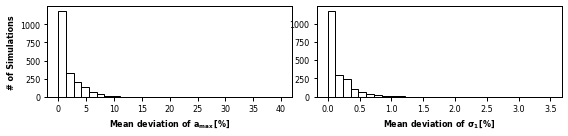

In [30]:
fig = plt.figure(figsize=(8,2))

outer  = gridspec.GridSpec(1, 1, figure=fig, wspace=0.0)
inner1 = outer[0].subgridspec(1, 2, wspace=0.1, hspace=0.05)
ax0  = fig.add_subplot(inner1[0])
ax1  = fig.add_subplot(inner1[1])

ax0.hist(np.ma.masked_where(deviation_a>1000,np.ma.masked_where(deviation_a <0, deviation_a)).compressed(), bins=np.linspace(0,40,30), fill=False)
# ax0.set_xlabel(r"$\mathbf{100\times\left\langle\frac{a_{max,act}-a_{max,pred}}{a_{max,act}}\right\rangle_t}$")
ax0.set_xlabel(r"Mean deviation of $\mathbf{a_{max} \,  [\%]}$")
ax0.set_ylabel('# of Simulations')

ax1.hist(np.ma.masked_where(deviation_sig>1000,np.ma.masked_where(deviation_sig <0, deviation_sig)).compressed(), bins=np.linspace(0,3.5,30), fill=False)
ax1.set_xlabel(r"Mean deviation of $\mathbf{\sigma_1 \,  [\%]}$")

outer.tight_layout(fig)